# Quarterly Analysis of Sydney Housing Data - Split by Houses and Units

This notebook performs quarterly analysis of Sydney housing data, split between houses and units.

**Data Sources:**
- `../data/sydney/full_houses.parquet` - House sales data
- `../data/sydney/full_units.parquet` - Unit sales data

**Analysis:**
- Quarterly aggregations per suburb for both property types
- Separate analytics tables for houses and units
- Comparative visualizations


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


In [2]:
houses_file = "../data/sydney/full_houses.parquet"
units_file = "../data/sydney/full_units.parquet"

print("Loading Sydney housing data...")

if Path(houses_file).exists():
    try:
        df_houses_raw = pd.read_parquet(houses_file, engine='fastparquet')
    except:
        df_houses_raw = pd.read_parquet(houses_file)
    print(f"Loaded {len(df_houses_raw):,} house records")
    print(f"  Date range: {df_houses_raw['settlement_date'].min().date()} to {df_houses_raw['settlement_date'].max().date()}")
else:
    raise FileNotFoundError(f"Houses parquet file not found: {houses_file}")

if Path(units_file).exists():
    try:
        df_units_raw = pd.read_parquet(units_file, engine='fastparquet')
    except:
        df_units_raw = pd.read_parquet(units_file)
    print(f"Loaded {len(df_units_raw):,} unit records")
    print(f"  Date range: {df_units_raw['settlement_date'].min().date()} to {df_units_raw['settlement_date'].max().date()}")
else:
    raise FileNotFoundError(f"Units parquet file not found: {units_file}")

print(f"\nTotal records: {len(df_houses_raw) + len(df_units_raw):,}")
print(f"  Houses: {len(df_houses_raw):,} ({len(df_houses_raw)/(len(df_houses_raw)+len(df_units_raw))*100:.1f}%)")
print(f"  Units: {len(df_units_raw):,} ({len(df_units_raw)/(len(df_houses_raw)+len(df_units_raw))*100:.1f}%)")


Loading Sydney housing data...
Loaded 880,748 house records
  Date range: 2005-01-01 to 2025-12-24
Loaded 1,073,061 unit records
  Date range: 2005-01-01 to 2025-12-24

Total records: 1,953,809
  Houses: 880,748 (45.1%)
  Units: 1,073,061 (54.9%)


In [3]:
# transform to properties schema
print("Transforming data to match properties table schema...")

def transform_properties(df_raw, property_type):
    """Transform raw data to properties schema"""
    df_properties = df_raw.copy()
    
    # Map columns to schema
    df_properties['suburb'] = df_properties['property_locality'].str.strip()
    df_properties['postcode'] = df_properties['property_post_code'].astype(str).str.strip()
    df_properties['district'] = df_properties['district_code'].astype(str).str.strip()
    df_properties['contract_date'] = pd.to_datetime(df_properties['contract_date'])
    df_properties['settlement_date'] = pd.to_datetime(df_properties['settlement_date'])
    df_properties['sale_price'] = df_properties['purchase_price'].astype(float)
    df_properties['property_type'] = property_type
    
    # Calculate days on market
    df_properties['contract_to_settlement_days'] = (
        (df_properties['settlement_date'] - df_properties['contract_date']).dt.days
    )
    
    # Filter out invalid records
    initial_count = len(df_properties)
    df_properties = df_properties[
        (df_properties['contract_to_settlement_days'] >= 0) &
        (df_properties['contract_date'].notna()) &
        (df_properties['settlement_date'].notna()) &
        (df_properties['sale_price'] > 0) &
        (df_properties['suburb'].notna())
    ].copy()
    
    print(f"  {property_type.capitalize()}: Filtered from {initial_count:,} to {len(df_properties):,} valid records")
    
    return df_properties

# Transform both datasets
df_houses = transform_properties(df_houses_raw, 'house')
df_units = transform_properties(df_units_raw, 'unit')

# combine for some analyses
df_all_properties = pd.concat([df_houses, df_units], ignore_index=True)

print(f"\nTotal valid records: {len(df_all_properties):,}")
print(f"  Houses: {len(df_houses):,}")
print(f"  Units: {len(df_units):,}")


Transforming data to match properties table schema...
  House: Filtered from 880,748 to 880,568 valid records
  Unit: Filtered from 1,073,061 to 1,072,888 valid records

Total valid records: 1,953,456
  Houses: 880,568
  Units: 1,072,888


In [4]:
# Add quarter information for quarterly analysis
def add_quarter_info(df):
    """Add quarter and month information to dataframe"""
    df = df.copy()
    df['year'] = df['settlement_date'].dt.year
    df['quarter'] = df['settlement_date'].dt.quarter
    df['quarter_start'] = df['settlement_date'].dt.to_period('Q').dt.start_time
    df['year_month'] = df['settlement_date'].dt.to_period('M')
    return df

df_houses = add_quarter_info(df_houses)
df_units = add_quarter_info(df_units)

print("Added quarter and month information:")
print(f"\nHouses:")
print(f"  Date range: {df_houses['settlement_date'].min()} to {df_houses['settlement_date'].max()}")
print(f"  Quarters: {df_houses['year'].min()}Q{df_houses[df_houses['year']==df_houses['year'].min()]['quarter'].min()} to {df_houses['year'].max()}Q{df_houses[df_houses['year']==df_houses['year'].max()]['quarter'].max()}")

print(f"\nUnits:")
print(f"  Date range: {df_units['settlement_date'].min()} to {df_units['settlement_date'].max()}")
print(f"  Quarters: {df_units['year'].min()}Q{df_units[df_units['year']==df_units['year'].min()]['quarter'].min()} to {df_units['year'].max()}Q{df_units[df_units['year']==df_units['year'].max()]['quarter'].max()}")


Added quarter and month information:

Houses:
  Date range: 2005-01-01 00:00:00 to 2025-12-24 00:00:00
  Quarters: 2005Q1 to 2025Q4

Units:
  Date range: 2005-01-01 00:00:00 to 2025-12-24 00:00:00
  Quarters: 2005Q1 to 2025Q4


## Quarterly Median Smoothing

**Problem**: Raw quarterly medians can be volatile due to small sample sizes, outliers, and natural market volatility.

**Solution**: **Exponential Smoothing** - A time-series smoothing technique that weights recent quarters more heavily while maintaining responsiveness to trends.

**Parameters**:
- `alpha`: Smoothing factor (0-1, default: 0.3) where higher values are more responsive to recent changes
- Formula: `S_t = α * X_t + (1-α) * S_{t-1}` where S is smoothed value and X is raw median


In [5]:
# Apply exponential smoothing to quarterly medians
print("Applying exponential smoothing to quarterly medians...")

def apply_exponential_smoothing(quarterly_stats, alpha=0.3):
    """
    Apply exponential smoothing to quarterly median prices per suburb.
    
    Parameters:
    - quarterly_stats: DataFrame with quarterly statistics
    - alpha: Smoothing factor (0-1, default: 0.3). Higher values are more responsive to recent changes.
             Formula: S_t = α * X_t + (1-α) * S_{t-1}
    
    Returns:
    - DataFrame with smoothed medians in 'sale_price_median_price_smoothed' column
    """
    quarterly_smoothed = quarterly_stats.copy()
    
    # Sort by suburb, year, quarter for proper time series ordering
    quarterly_smoothed = quarterly_smoothed.sort_values(['suburb', 'year', 'quarter']).reset_index(drop=True)
    
    def exponential_smooth(suburb_group):
        """Apply exponential smoothing to a suburb's time series"""
        medians = suburb_group['sale_price_median_price'].values
        
        # Handle edge cases
        if len(medians) == 0:
            suburb_group['sale_price_median_price_smoothed'] = []
            return suburb_group
        
        if len(medians) == 1:
            suburb_group['sale_price_median_price_smoothed'] = medians
            return suburb_group
        
        # Initialize smoothed array
        smoothed = []
        
        # Find first non-NaN value to start smoothing
        first_valid_idx = None
        for i in range(len(medians)):
            if pd.notna(medians[i]):
                first_valid_idx = i
                break
        
        # If all values are NaN, return original
        if first_valid_idx is None:
            suburb_group['sale_price_median_price_smoothed'] = medians
            return suburb_group
        
        # Fill leading NaN values with the first valid value
        for i in range(first_valid_idx):
            smoothed.append(medians[first_valid_idx])
        
        # Start with first valid value
        smoothed.append(medians[first_valid_idx])
        
        # Apply exponential smoothing from the first non-NaN value
        for i in range(first_valid_idx + 1, len(medians)):
            if pd.notna(medians[i]):
                # Exponential smoothing: S_t = α * X_t + (1-α) * S_{t-1}
                smoothed_value = alpha * medians[i] + (1 - alpha) * smoothed[-1]
                smoothed.append(smoothed_value)
            else:
                # If current value is NaN, use previous smoothed value
                smoothed.append(smoothed[-1])
        
        suburb_group['sale_price_median_price_smoothed'] = smoothed
        return suburb_group
    
    quarterly_smoothed = quarterly_smoothed.groupby('suburb', group_keys=False).apply(exponential_smooth)
    
    return quarterly_smoothed

# Configuration
EXPONENTIAL_ALPHA = 0.3

print(f"Exponential smoothing alpha: {EXPONENTIAL_ALPHA}")
print("="*80)


Applying exponential smoothing to quarterly medians...
Exponential smoothing alpha: 0.3


## Apply Smoothing to All Quarterly Data

Applying exponential smoothing to all quarterly statistics for both houses and units.


In [6]:
# Create quarterly aggregations per suburb - for both houses and units
print("Creating quarterly aggregations per suburb...")

def create_quarterly_stats(df, property_type):
    """Create quarterly statistics for a property type"""
    print(f"\nProcessing {property_type}...")
    
    quarterly_stats = df.groupby(['suburb', 'year', 'quarter', 'quarter_start']).agg({
        'sale_price': [
            ('num_sales', 'count'),
            ('median_price', 'median'),
            ('mean_price', 'mean'),
            ('min_price', 'min'),
            ('max_price', 'max'),
            ('price_stddev', 'std'),
            ('price_p25', lambda x: x.quantile(0.25)),
            ('price_p75', lambda x: x.quantile(0.75)),
        ],
        'contract_to_settlement_days': [
            ('median_ctsd', 'median'),
            ('mean_ctsd', 'mean'),
        ]
    }).reset_index()
    
    # Flatten column names
    quarterly_stats.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in quarterly_stats.columns.values]
    
    # Calculate fast sales percentage (sold within 30 days)
    fast_settlements = df[df['contract_to_settlement_days'] <= 30].groupby(
        ['suburb', 'year', 'quarter']
    ).size().reset_index(name='fast_settlement_count')
    
    total_sales = df.groupby(['suburb', 'year', 'quarter']).size().reset_index(name='total_sales_count')
    
    fast_settlements_pct = pd.merge(fast_settlements, total_sales, on=['suburb', 'year', 'quarter'], how='right')
    fast_settlements_pct['fast_settlements_percentage'] = (
        (fast_settlements_pct['fast_settlement_count'].fillna(0) / fast_settlements_pct['total_sales_count']) * 100
    )
    
    # Merge fast sales percentage into quarterly stats
    quarterly_stats = pd.merge(
        quarterly_stats, 
        fast_settlements_pct[['suburb', 'year', 'quarter', 'fast_settlements_percentage']],
        on=['suburb', 'year', 'quarter'],
        how='left'
    )
    
    # Calculate liquidity score
    volume_max = quarterly_stats['sale_price_num_sales'].max()
    quarterly_stats['volume_score'] = quarterly_stats['sale_price_num_sales'] / volume_max if volume_max > 0 else 0
    quarterly_stats['speed_score'] = (100 - quarterly_stats['fast_settlements_percentage'].fillna(0)) / 100
    quarterly_stats['liquidity_score'] = (quarterly_stats['volume_score'] * 0.6 + quarterly_stats['speed_score'] * 0.4)
    
    quarterly_stats['property_type'] = property_type
    
    print(f"   Created quarterly stats for {len(quarterly_stats):,} suburb-quarter combinations")
    print(f"   Unique suburbs: {quarterly_stats['suburb'].nunique()}")
    
    return quarterly_stats

# Create quarterly stats for both property types
quarterly_stats_houses = create_quarterly_stats(df_houses, 'house')
quarterly_stats_units = create_quarterly_stats(df_units, 'unit')

# Combine for some analyses
quarterly_stats_all = pd.concat([quarterly_stats_houses, quarterly_stats_units], ignore_index=True)

print(f"\nSUCCESS: Total quarterly stats records: {len(quarterly_stats_all):,}")
print(f"  Houses: {len(quarterly_stats_houses):,}")
print(f"  Units: {len(quarterly_stats_units):,}")


Creating quarterly aggregations per suburb...

Processing house...
   Created quarterly stats for 47,016 suburb-quarter combinations
   Unique suburbs: 649

Processing unit...
   Created quarterly stats for 34,001 suburb-quarter combinations
   Unique suburbs: 583

SUCCESS: Total quarterly stats records: 81,017
  Houses: 47,016
  Units: 34,001


In [7]:

print("\nProcessing houses...")

# Check if quarterly_stats_houses exists
if 'quarterly_stats_houses' not in globals():
    raise NameError("quarterly_stats_houses not found. Please run the cell that creates quarterly_stats_houses first (cell 9).")

quarterly_stats_houses_smoothed = apply_exponential_smoothing(quarterly_stats_houses, alpha=EXPONENTIAL_ALPHA)

# Apply exponential smoothing to units
print("Processing units...")

# Check if quarterly_stats_units exists
if 'quarterly_stats_units' not in globals():
    raise NameError("quarterly_stats_units not found. Please run the cell that creates quarterly_stats_units first (cell 9).")

quarterly_stats_units_smoothed = apply_exponential_smoothing(quarterly_stats_units, alpha=EXPONENTIAL_ALPHA)

# Keep both raw and smoothed median prices
# Raw median is the original unsmoothed value
# Smoothed median is the exponentially smoothed value
quarterly_stats_houses_smoothed['sale_price_median_price_raw'] = quarterly_stats_houses_smoothed['sale_price_median_price']
quarterly_stats_houses_smoothed['sale_price_median_price_smoothed'] = quarterly_stats_houses_smoothed['sale_price_median_price_smoothed']

quarterly_stats_units_smoothed['sale_price_median_price_raw'] = quarterly_stats_units_smoothed['sale_price_median_price']
quarterly_stats_units_smoothed['sale_price_median_price_smoothed'] = quarterly_stats_units_smoothed['sale_price_median_price_smoothed']

# Keep the smoothed version as the main median_price column for most analyses
# But both raw and smoothed are available
quarterly_stats_houses_smoothed['sale_price_median_price'] = quarterly_stats_houses_smoothed['sale_price_median_price_smoothed']
quarterly_stats_units_smoothed['sale_price_median_price'] = quarterly_stats_units_smoothed['sale_price_median_price_smoothed']

# Update the main quarterly_stats variables
quarterly_stats_houses = quarterly_stats_houses_smoothed.copy()
quarterly_stats_units = quarterly_stats_units_smoothed.copy()

# Combine for some analyses
quarterly_stats_all = pd.concat([quarterly_stats_houses, quarterly_stats_units], ignore_index=True)

print("\n" + "="*80)
print("SMOOTHING COMPLETE")
print("="*80)
print(f"\nSUCCESS: Smoothed {len(quarterly_stats_houses):,} house quarterly records")
print(f"         Smoothed {len(quarterly_stats_units):,} unit quarterly records")
print(f"\nNote: Original medians preserved in 'sale_price_median_price_raw' column")
print(f"      Smoothed medians are now in 'sale_price_median_price' column")

# Show impact statistics
print("\n" + "-"*80)
print("SMOOTHING IMPACT STATISTICS")
print("-"*80)

def calculate_volatility_reduction(stats_df, property_type):
    """Calculate how much smoothing reduced volatility"""
    # Calculate volatility before and after smoothing
    volatility_raw = stats_df.groupby('suburb')['sale_price_median_price_raw'].apply(
        lambda x: x.pct_change().std() if len(x) > 1 else 0
    )
    volatility_smoothed = stats_df.groupby('suburb')['sale_price_median_price'].apply(
        lambda x: x.pct_change().std() if len(x) > 1 else 0
    )
    
    reduction = ((volatility_raw - volatility_smoothed) / volatility_raw * 100).fillna(0)
    
    print(f"\n{property_type.upper()}:")
    print(f"  Average volatility (raw): {volatility_raw.mean():.4f}")
    print(f"  Average volatility (smoothed): {volatility_smoothed.mean():.4f}")
    print(f"  Average reduction: {reduction.mean():.1f}%")
    print(f"  Median reduction: {reduction.median():.1f}%")
    
    return reduction

reduction_houses = calculate_volatility_reduction(quarterly_stats_houses, 'houses')
reduction_units = calculate_volatility_reduction(quarterly_stats_units, 'units')

print("\n" + "="*80)



Processing houses...
Processing units...

SMOOTHING COMPLETE

SUCCESS: Smoothed 47,016 house quarterly records
         Smoothed 34,001 unit quarterly records

Note: Original medians preserved in 'sale_price_median_price_raw' column
      Smoothed medians are now in 'sale_price_median_price' column

--------------------------------------------------------------------------------
SMOOTHING IMPACT STATISTICS
--------------------------------------------------------------------------------

HOUSES:
  Average volatility (raw): 1.0096
  Average volatility (smoothed): 0.1148
  Average reduction: 73.0%
  Median reduction: 72.8%

UNITS:
  Average volatility (raw): 0.8646
  Average volatility (smoothed): 0.1595
  Average reduction: 64.8%
  Median reduction: 74.1%



In [8]:
# Create suburb_analytics table structure - for both houses and units
print("Creating suburb_analytics tables...")

def create_suburb_analytics(df, quarterly_stats, property_type):
    """Create suburb analytics for a property type"""
    print(f"\nProcessing {property_type} analytics...")
    
    # Get current date for "last 12 months" calculations
    current_date = df['settlement_date'].max()
    one_year_ago = current_date - pd.Timedelta(days=365)
    
    # Current metrics (last 12 months)
    recent_sales = df[df['settlement_date'] >= one_year_ago]
    current_metrics = recent_sales.groupby('suburb').agg({
        'sale_price': 'median',
        'contract_to_settlement_days': 'mean',
        'settlement_date': 'count'
    }).reset_index()
    current_metrics.columns = ['suburb', 'current_median_price', 'current_avg_ctsd', 'total_sales_last_12m']
    
    # Growth rates - compare current median to past periods
    all_time_median = df.groupby('suburb')['sale_price'].median().reset_index()
    all_time_median.columns = ['suburb', 'all_time_median']
    
    # Get median prices for different time periods
    three_years_ago = current_date - pd.Timedelta(days=365*3)
    five_years_ago = current_date - pd.Timedelta(days=365*5)
    ten_years_ago = current_date - pd.Timedelta(days=365*10)
    
    median_3yr_ago = df[
        (df['settlement_date'] >= three_years_ago - pd.Timedelta(days=90)) &
        (df['settlement_date'] < three_years_ago + pd.Timedelta(days=90))
    ].groupby('suburb')['sale_price'].median().reset_index()
    median_3yr_ago.columns = ['suburb', 'median_3yr_ago']
    
    median_5yr_ago = df[
        (df['settlement_date'] >= five_years_ago - pd.Timedelta(days=90)) &
        (df['settlement_date'] < five_years_ago + pd.Timedelta(days=90))
    ].groupby('suburb')['sale_price'].median().reset_index()
    median_5yr_ago.columns = ['suburb', 'median_5yr_ago']
    
    median_10yr_ago = df[
        (df['settlement_date'] >= ten_years_ago - pd.Timedelta(days=90)) &
        (df['settlement_date'] < ten_years_ago + pd.Timedelta(days=90))
    ].groupby('suburb')['sale_price'].median().reset_index()
    median_10yr_ago.columns = ['suburb', 'median_10yr_ago']
    
    # Calculate growth rates
    suburb_analytics = current_metrics.copy()
    suburb_analytics = pd.merge(suburb_analytics, all_time_median, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, median_3yr_ago, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, median_5yr_ago, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, median_10yr_ago, on='suburb', how='left')
    
    # Calculate raw growth percentages
    suburb_analytics['growth_1yr_pct'] = (
        ((suburb_analytics['current_median_price'] - suburb_analytics['median_3yr_ago']) / 
         suburb_analytics['median_3yr_ago'] * 100).fillna(0)
    )
    suburb_analytics['growth_3yr_pct'] = (
        ((suburb_analytics['current_median_price'] - suburb_analytics['median_5yr_ago']) / 
         suburb_analytics['median_5yr_ago'] * 100).fillna(0)
    )
    suburb_analytics['growth_5yr_pct'] = (
        ((suburb_analytics['current_median_price'] - suburb_analytics['median_10yr_ago']) / 
         suburb_analytics['median_10yr_ago'] * 100).fillna(0)
    )
    
    # Get earliest data point for "since 2005" growth
    earliest_median = df.groupby('suburb').apply(
        lambda x: x.nsmallest(min(10, len(x)), 'settlement_date')['sale_price'].median()
    ).reset_index()
    earliest_median.columns = ['suburb', 'earliest_median']
    
    suburb_analytics = pd.merge(suburb_analytics, earliest_median, on='suburb', how='left')
    suburb_analytics['growth_since_2005_pct'] = (
        ((suburb_analytics['current_median_price'] - suburb_analytics['earliest_median']) / 
         suburb_analytics['earliest_median'] * 100).fillna(0)
    )
    
    # Calculate smoothed metrics from quarterly_stats
    # Get most recent quarter's smoothed median price
    quarterly_sorted = quarterly_stats.sort_values(['suburb', 'year', 'quarter'])
    most_recent_quarter = quarterly_sorted.groupby('suburb').tail(1)[['suburb', 'sale_price_median_price_smoothed']].copy()
    most_recent_quarter.columns = ['suburb', 'current_median_price_smoothed']
    suburb_analytics = pd.merge(suburb_analytics, most_recent_quarter, on='suburb', how='left')
    
    # Get smoothed medians from quarterly_stats for historical periods
    # Create quarter index for each suburb
    quarterly_sorted['quarter_idx'] = quarterly_sorted.groupby('suburb').cumcount()
    total_quarters = quarterly_sorted.groupby('suburb').size().reset_index(name='total_q')
    quarterly_sorted = pd.merge(quarterly_sorted, total_quarters, on='suburb')
    
    # Get smoothed median from ~12 quarters ago (3 years)
    smoothed_3yr_ago = quarterly_sorted[
        (quarterly_sorted['quarter_idx'] >= quarterly_sorted['total_q'] - 14) &
        (quarterly_sorted['quarter_idx'] <= quarterly_sorted['total_q'] - 10)
    ].groupby('suburb')['sale_price_median_price_smoothed'].median().reset_index()
    smoothed_3yr_ago.columns = ['suburb', 'smoothed_median_3yr_ago']
    
    # Get smoothed median from ~20 quarters ago (5 years)
    smoothed_5yr_ago = quarterly_sorted[
        (quarterly_sorted['quarter_idx'] >= quarterly_sorted['total_q'] - 22) &
        (quarterly_sorted['quarter_idx'] <= quarterly_sorted['total_q'] - 18)
    ].groupby('suburb')['sale_price_median_price_smoothed'].median().reset_index()
    smoothed_5yr_ago.columns = ['suburb', 'smoothed_median_5yr_ago']
    
    # Get smoothed median from ~40 quarters ago (10 years)
    smoothed_10yr_ago = quarterly_sorted[
        (quarterly_sorted['quarter_idx'] >= quarterly_sorted['total_q'] - 42) &
        (quarterly_sorted['quarter_idx'] <= quarterly_sorted['total_q'] - 38)
    ].groupby('suburb')['sale_price_median_price_smoothed'].median().reset_index()
    smoothed_10yr_ago.columns = ['suburb', 'smoothed_median_10yr_ago']
    
    # Get earliest smoothed median (first 4 quarters)
    smoothed_earliest = quarterly_sorted.groupby('suburb').head(4).groupby('suburb')['sale_price_median_price_smoothed'].median().reset_index()
    smoothed_earliest.columns = ['suburb', 'smoothed_earliest_median']
    
    # Merge smoothed historical medians
    suburb_analytics = pd.merge(suburb_analytics, smoothed_3yr_ago, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, smoothed_5yr_ago, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, smoothed_10yr_ago, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, smoothed_earliest, on='suburb', how='left')
    
    # Calculate smoothed growth percentages
    suburb_analytics['growth_1yr_pct_smoothed'] = (
        ((suburb_analytics['current_median_price_smoothed'] - suburb_analytics['smoothed_median_3yr_ago']) / 
         suburb_analytics['smoothed_median_3yr_ago'] * 100).fillna(0)
    )
    suburb_analytics['growth_3yr_pct_smoothed'] = (
        ((suburb_analytics['current_median_price_smoothed'] - suburb_analytics['smoothed_median_5yr_ago']) / 
         suburb_analytics['smoothed_median_5yr_ago'] * 100).fillna(0)
    )
    suburb_analytics['growth_5yr_pct_smoothed'] = (
        ((suburb_analytics['current_median_price_smoothed'] - suburb_analytics['smoothed_median_10yr_ago']) / 
         suburb_analytics['smoothed_median_10yr_ago'] * 100).fillna(0)
    )
    suburb_analytics['growth_since_2005_pct_smoothed'] = (
        ((suburb_analytics['current_median_price_smoothed'] - suburb_analytics['smoothed_earliest_median']) / 
         suburb_analytics['smoothed_earliest_median'] * 100).fillna(0)
    )
    
    suburb_analytics['property_type'] = property_type
    
    print(f"   Created analytics for {len(suburb_analytics):,} suburbs")
    
    return suburb_analytics

# Create analytics for both property types
suburb_analytics_houses = create_suburb_analytics(df_houses, quarterly_stats_houses, 'house')
suburb_analytics_units = create_suburb_analytics(df_units, quarterly_stats_units, 'unit')

print(f"\nSUCCESS: Analytics created:")
print(f"  Houses: {len(suburb_analytics_houses):,} suburbs")
print(f"  Units: {len(suburb_analytics_units):,} suburbs")


Creating suburb_analytics tables...

Processing house analytics...
   Created analytics for 633 suburbs

Processing unit analytics...
   Created analytics for 526 suburbs

SUCCESS: Analytics created:
  Houses: 633 suburbs
  Units: 526 suburbs


In [9]:
# Create quarterly time series as JSON strings for suburb_analytics
print("Creating quarterly time series JSON...")

def add_quarterly_json(suburb_analytics, quarterly_stats, property_type):
    """Add quarterly JSON time series to suburb analytics"""
    print(f"\nProcessing {property_type} quarterly JSON...")
    
    # Prepare quarterly data for JSON serialization
    ctsdcolumn = [col for col in quarterly_stats.columns if 'contract_to_settlement' in col and 'median' in col.lower()]
    if not ctsdcolumn:
        ctsdcolumn = [col for col in quarterly_stats.columns if 'dom' in col.lower() or 'days' in col.lower()]
    
    if ctsdcolumn:
        ctsdcol_name = ctsdcolumn[0]
    else:
        print(f"  Warning: Could not find days on market column for {property_type}")
        ctsdcol_name = None
    
    if ctsdcol_name:
        quarterly_for_json = quarterly_stats[[
            'suburb', 'year', 'quarter', 'sale_price_median_price', ctsdcol_name
        ]].copy()
        quarterly_for_json.columns = ['suburb', 'year', 'quarter', 'median_price', 'median_ctsd']
    else:
        quarterly_for_json = quarterly_stats[[
            'suburb', 'year', 'quarter', 'sale_price_median_price'
        ]].copy()
        quarterly_for_json['median_ctsd'] = 0
        quarterly_for_json.columns = ['suburb', 'year', 'quarter', 'median_price', 'median_ctsd']
    
    # Create price_quarterly JSON
    price_quarterly_json = quarterly_for_json.groupby('suburb').apply(
        lambda x: json.dumps([
            {
                'year': int(row['year']),
                'quarter': int(row['quarter']),
                'median_price': float(row['median_price']) if pd.notna(row['median_price']) else None
            }
            for _, row in x.iterrows()
        ], default=str)
    ).reset_index()
    price_quarterly_json.columns = ['suburb', 'price_quarterly']
    
    # Create ctsdquarterly JSON
    ctsdquarterly_json = quarterly_for_json.groupby('suburb').apply(
        lambda x: json.dumps([
            {
                'year': int(row['year']),
                'quarter': int(row['quarter']),
                'median_ctsd': float(row['median_ctsd']) if pd.notna(row['median_ctsd']) else None
            }
            for _, row in x.iterrows()
        ], default=str)
    ).reset_index()
    ctsdquarterly_json.columns = ['suburb', 'ctsdquarterly']
    
    # Merge JSON time series into suburb_analytics
    suburb_analytics = pd.merge(suburb_analytics, price_quarterly_json, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, ctsdquarterly_json, on='suburb', how='left')
    
    # Add last_updated timestamp
    suburb_analytics['last_updated'] = datetime.now().isoformat()
    
    print(f"   Added quarterly time series JSON for {property_type}")
    
    return suburb_analytics

# Add quarterly JSON to both analytics tables
suburb_analytics_houses = add_quarterly_json(suburb_analytics_houses, quarterly_stats_houses, 'house')
suburb_analytics_units = add_quarterly_json(suburb_analytics_units, quarterly_stats_units, 'unit')


Creating quarterly time series JSON...

Processing house quarterly JSON...
   Added quarterly time series JSON for house

Processing unit quarterly JSON...
   Added quarterly time series JSON for unit


In [10]:
# Calculate volatility, market health, and liquidity scores
print("Calculating risk and market health scores...")

def calculate_scores(suburb_analytics, quarterly_stats, property_type):
    """Calculate risk and market health scores"""
    print(f"\nProcessing {property_type} scores...")
    
    # Volatility: standard deviation of quarterly price changes
    quarterly_sorted = quarterly_stats.sort_values(['suburb', 'year', 'quarter'])
    price_changes = quarterly_sorted.groupby('suburb')['sale_price_median_price'].apply(
        lambda x: x.pct_change().std() if len(x) > 1 else 0
    ).reset_index()
    price_changes.columns = ['suburb', 'volatility_score']
    price_changes['volatility_score'] = price_changes['volatility_score'].fillna(0)
    
    # Market health: composite of growth, volume, and stability
    def calculate_price_trend(group):
        """Calculate price trend from first to last quarter"""
        sorted_group = group.sort_values(['year', 'quarter'])
        if len(sorted_group) > 1:
            first_price = sorted_group['sale_price_median_price'].iloc[0]
            last_price = sorted_group['sale_price_median_price'].iloc[-1]
            if first_price > 0:
                return (last_price / first_price - 1)
        return 0
    
    market_health = quarterly_stats.groupby('suburb').agg({
        'sale_price_num_sales': 'mean',
        'liquidity_score': 'mean',
    }).reset_index()
    market_health.columns = ['suburb', 'avg_volume', 'avg_liquidity']
    
    # Calculate price trend separately with proper sorting
    price_trends = quarterly_sorted.groupby('suburb').apply(
        lambda x: calculate_price_trend(x)
    ).reset_index()
    price_trends.columns = ['suburb', 'price_trend']
    
    market_health = pd.merge(market_health, price_trends, on='suburb', how='left')
    
    # Normalize components and calculate composite score
    market_health['market_health_score'] = (
        (market_health['avg_volume'] / market_health['avg_volume'].max() * 0.4 +
         market_health['avg_liquidity'] * 0.4 +
         (market_health['price_trend'].fillna(0) + 1) / 2 * 0.2).fillna(0)
    )
    
    # Liquidity score: average from quarterly stats
    liquidity_avg = quarterly_stats.groupby('suburb')['liquidity_score'].mean().reset_index()
    liquidity_avg.columns = ['suburb', 'liquidity_score']
    
    # Merge scores into suburb_analytics
    suburb_analytics = pd.merge(suburb_analytics, price_changes, on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, market_health[['suburb', 'market_health_score']], on='suburb', how='left')
    suburb_analytics = pd.merge(suburb_analytics, liquidity_avg, on='suburb', how='left')
    
    print(f"   Calculated scores for {property_type}")
    
    return suburb_analytics

# Calculate scores for both property types
suburb_analytics_houses = calculate_scores(suburb_analytics_houses, quarterly_stats_houses, 'house')
suburb_analytics_units = calculate_scores(suburb_analytics_units, quarterly_stats_units, 'unit')


Calculating risk and market health scores...

Processing house scores...
   Calculated scores for house

Processing unit scores...
   Calculated scores for unit


In [11]:
# Add rankings
print("Adding rankings...")

def add_rankings(suburb_analytics, property_type):
    """Add rankings to suburb analytics"""
    print(f"\nProcessing {property_type} rankings...")
    
    suburb_analytics['price_rank'] = suburb_analytics['current_median_price'].rank(ascending=False, method='min').astype(int)
    suburb_analytics['growth_rank'] = suburb_analytics['growth_1yr_pct'].rank(ascending=False, method='min').astype(int)
    suburb_analytics['speed_rank'] = suburb_analytics['current_avg_ctsd'].rank(ascending=True, method='min').astype(int)
    
    print(f"   Added rankings for {property_type}")
    
    return suburb_analytics

# Add rankings to both analytics tables
suburb_analytics_houses = add_rankings(suburb_analytics_houses, 'house')
suburb_analytics_units = add_rankings(suburb_analytics_units, 'unit')

print(f"\nSUCCESS: Rankings added")
print(f"\nTop 5 houses by price:")
print(suburb_analytics_houses.nlargest(5, 'current_median_price')[['suburb', 'current_median_price', 'price_rank']])
print(f"\nTop 5 units by price:")
print(suburb_analytics_units.nlargest(5, 'current_median_price')[['suburb', 'current_median_price', 'price_rank']])


Adding rankings...

Processing house rankings...
   Added rankings for house

Processing unit rankings...
   Added rankings for unit

SUCCESS: Rankings added

Top 5 houses by price:
            suburb  current_median_price  price_rank
560         SYDNEY           109430000.0           1
473    POINT PIPER            60500000.0           2
207  ELIZABETH BAY            40110000.0           3
286    HUNTINGWOOD            21100000.0           4
44   BELLEVUE HILL            13000000.0           5

Top 5 units by price:
               suburb  current_median_price  price_rank
383       POINT PIPER             7720000.0           1
209  GREENHILLS BEACH             5600000.0           2
30            BAYVIEW             3900000.0           3
137       DAWES POINT             3700000.0           4
24         BARANGAROO             3635000.0           5


In [12]:
# Display final analytics structure
print("="*80)
print("FINAL ANALYTICS TABLE STRUCTURES")
print("="*80)

print(f"\nHouses Analytics:")
print(f"  Shape: {suburb_analytics_houses.shape}")
print(f"  Columns: {list(suburb_analytics_houses.columns)}")
print(f"  Total suburbs: {len(suburb_analytics_houses):,}")
print(f"  Suburbs with data in last 12 months: {len(suburb_analytics_houses[suburb_analytics_houses['total_sales_last_12m'] > 0]):,}")

print(f"\nUnits Analytics:")
print(f"  Shape: {suburb_analytics_units.shape}")
print(f"  Columns: {list(suburb_analytics_units.columns)}")
print(f"  Total suburbs: {len(suburb_analytics_units):,}")
print(f"  Suburbs with data in last 12 months: {len(suburb_analytics_units[suburb_analytics_units['total_sales_last_12m'] > 0]):,}")

print(f"\nPrice Statistics Comparison:")
print(f"\nHouses:")
print(suburb_analytics_houses['current_median_price'].describe())
print(f"\nUnits:")
print(suburb_analytics_units['current_median_price'].describe())


FINAL ANALYTICS TABLE STRUCTURES

Houses Analytics:
  Shape: (633, 32)
  Columns: ['suburb', 'current_median_price', 'current_avg_ctsd', 'total_sales_last_12m', 'all_time_median', 'median_3yr_ago', 'median_5yr_ago', 'median_10yr_ago', 'growth_1yr_pct', 'growth_3yr_pct', 'growth_5yr_pct', 'earliest_median', 'growth_since_2005_pct', 'current_median_price_smoothed', 'smoothed_median_3yr_ago', 'smoothed_median_5yr_ago', 'smoothed_median_10yr_ago', 'smoothed_earliest_median', 'growth_1yr_pct_smoothed', 'growth_3yr_pct_smoothed', 'growth_5yr_pct_smoothed', 'growth_since_2005_pct_smoothed', 'property_type', 'price_quarterly', 'ctsdquarterly', 'last_updated', 'volatility_score', 'market_health_score', 'liquidity_score', 'price_rank', 'growth_rank', 'speed_rank']
  Total suburbs: 633
  Suburbs with data in last 12 months: 633

Units Analytics:
  Shape: (526, 32)
  Columns: ['suburb', 'current_median_price', 'current_avg_ctsd', 'total_sales_last_12m', 'all_time_median', 'median_3yr_ago', 'median

Creating comparative visualizations...


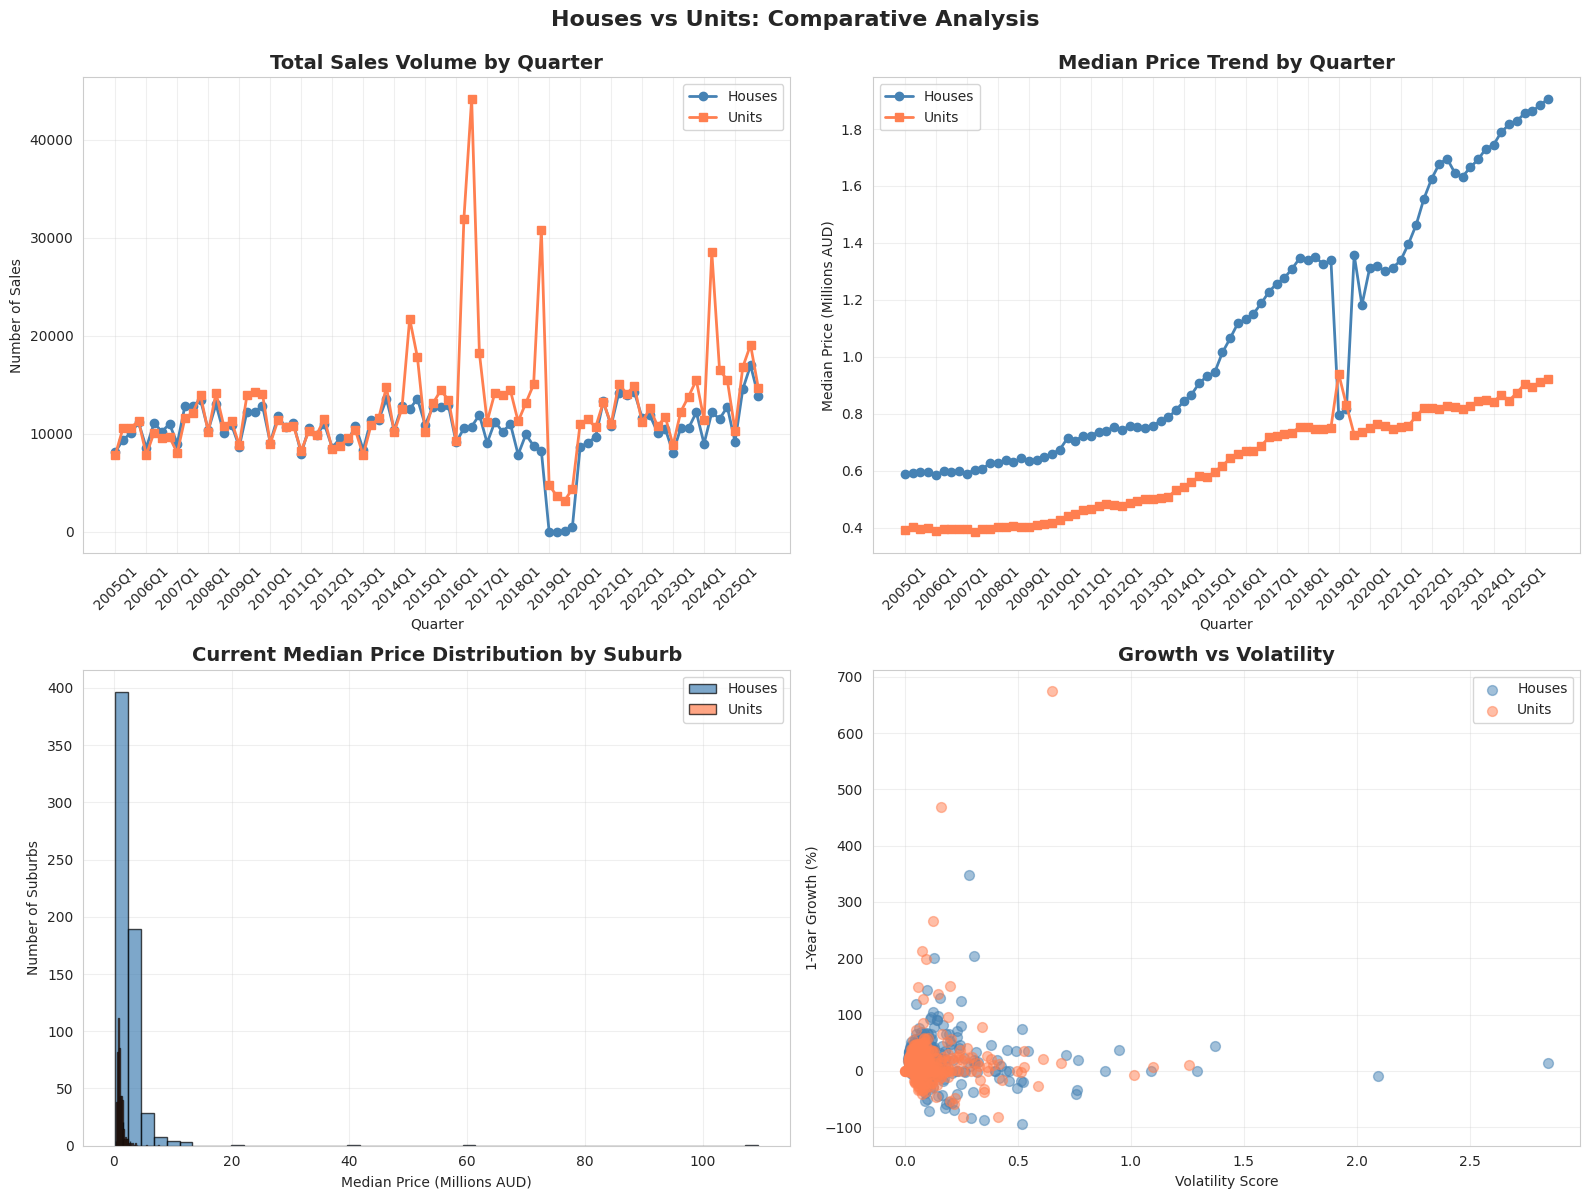

 Visualizations created


In [13]:
# Comparative Visualizations: Houses vs Units
print("Creating comparative visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall quarterly sales volume comparison
quarterly_volume_houses = quarterly_stats_houses.groupby(['year', 'quarter']).agg({
    'sale_price_num_sales': 'sum'
}).reset_index()
quarterly_volume_houses['quarter_label'] = quarterly_volume_houses['year'].astype(str) + 'Q' + quarterly_volume_houses['quarter'].astype(str)

quarterly_volume_units = quarterly_stats_units.groupby(['year', 'quarter']).agg({
    'sale_price_num_sales': 'sum'
}).reset_index()
quarterly_volume_units['quarter_label'] = quarterly_volume_units['year'].astype(str) + 'Q' + quarterly_volume_units['quarter'].astype(str)

axes[0, 0].plot(range(len(quarterly_volume_houses)), quarterly_volume_houses['sale_price_num_sales'], 
                marker='o', linewidth=2, label='Houses', color='steelblue')
axes[0, 0].plot(range(len(quarterly_volume_units)), quarterly_volume_units['sale_price_num_sales'], 
                marker='s', linewidth=2, label='Units', color='coral')
axes[0, 0].set_title('Total Sales Volume by Quarter', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Quarter')
axes[0, 0].set_ylabel('Number of Sales')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(range(0, len(quarterly_volume_houses), 4))
axes[0, 0].set_xticklabels(quarterly_volume_houses['quarter_label'][::4], rotation=45)

# 2. Overall median price trend comparison
quarterly_price_houses = quarterly_stats_houses.groupby(['year', 'quarter']).agg({
    'sale_price_median_price': 'median'
}).reset_index()
quarterly_price_houses['quarter_label'] = quarterly_price_houses['year'].astype(str) + 'Q' + quarterly_price_houses['quarter'].astype(str)

quarterly_price_units = quarterly_stats_units.groupby(['year', 'quarter']).agg({
    'sale_price_median_price': 'median'
}).reset_index()
quarterly_price_units['quarter_label'] = quarterly_price_units['year'].astype(str) + 'Q' + quarterly_price_units['quarter'].astype(str)

axes[0, 1].plot(range(len(quarterly_price_houses)), quarterly_price_houses['sale_price_median_price'] / 1e6, 
                marker='o', linewidth=2, label='Houses', color='steelblue')
axes[0, 1].plot(range(len(quarterly_price_units)), quarterly_price_units['sale_price_median_price'] / 1e6, 
                marker='s', linewidth=2, label='Units', color='coral')
axes[0, 1].set_title('Median Price Trend by Quarter', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quarter')
axes[0, 1].set_ylabel('Median Price (Millions AUD)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(0, len(quarterly_price_houses), 4))
axes[0, 1].set_xticklabels(quarterly_price_houses['quarter_label'][::4], rotation=45)

# 3. Price distribution comparison
axes[1, 0].hist(suburb_analytics_houses['current_median_price'] / 1e6, bins=50, 
                alpha=0.7, label='Houses', color='steelblue', edgecolor='black')
axes[1, 0].hist(suburb_analytics_units['current_median_price'] / 1e6, bins=50, 
                alpha=0.7, label='Units', color='coral', edgecolor='black')
axes[1, 0].set_title('Current Median Price Distribution by Suburb', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Median Price (Millions AUD)')
axes[1, 0].set_ylabel('Number of Suburbs')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Growth comparison
axes[1, 1].scatter(suburb_analytics_houses['volatility_score'], suburb_analytics_houses['growth_1yr_pct'], 
                   alpha=0.5, s=50, label='Houses', color='steelblue')
axes[1, 1].scatter(suburb_analytics_units['volatility_score'], suburb_analytics_units['growth_1yr_pct'], 
                   alpha=0.5, s=50, label='Units', color='coral')
axes[1, 1].set_title('Growth vs Volatility', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Volatility Score')
axes[1, 1].set_ylabel('1-Year Growth (%)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Houses vs Units: Comparative Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(" Visualizations created")


Comparing Houses vs Units for: TEMPE


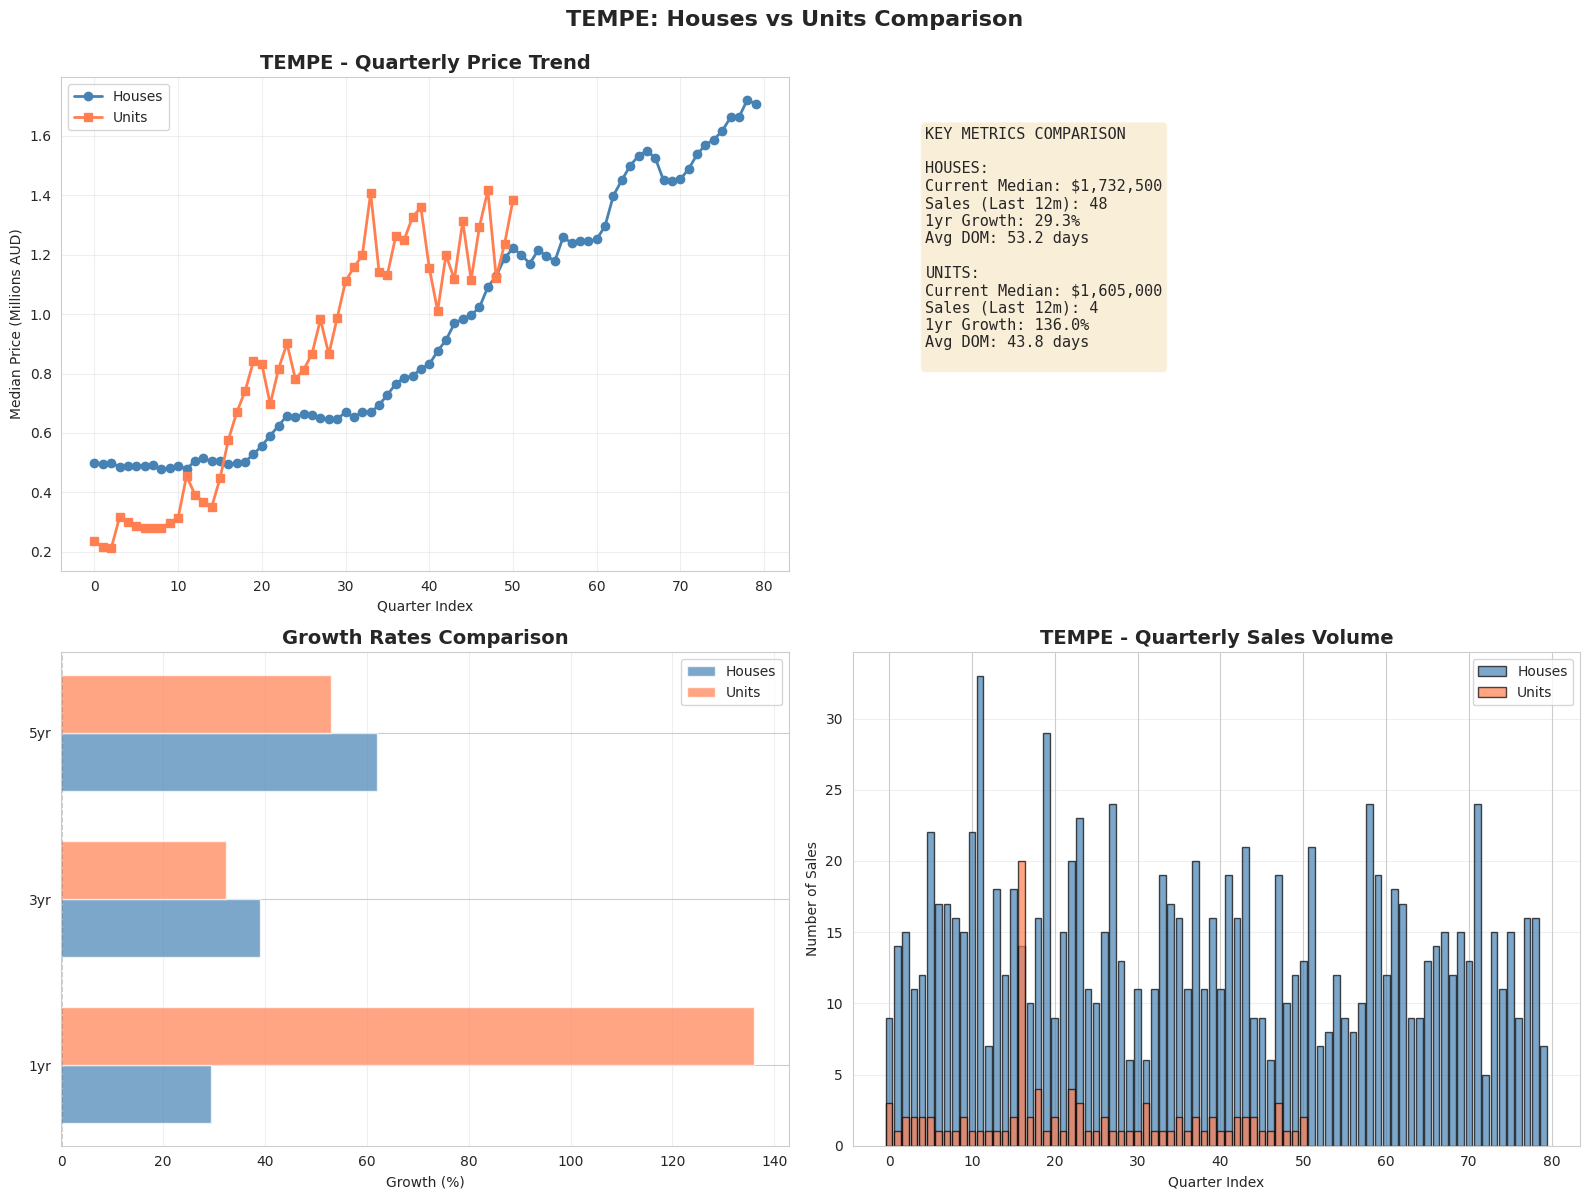


Detailed Comparison:

HOUSES:
  Current Median: $1,732,500.00
  Sales (Last 12m): 48
  1yr Growth: 29.29%
  Avg DOM: 53.2 days

UNITS:
  Current Median: $1,605,000.00
  Sales (Last 12m): 4
  1yr Growth: 136.03%
  Avg CTSD: 43.8 days

Price Difference: Houses are 7.9% more expensive than Units


In [14]:
# Suburb-specific comparison: Houses vs Units
SELECTED_SUBURB = "TEMPE"

print(f"Comparing Houses vs Units for: {SELECTED_SUBURB}")
print("="*80)

# Get suburb data for both property types
suburb_houses = suburb_analytics_houses[suburb_analytics_houses['suburb'].str.upper() == SELECTED_SUBURB.upper()]
suburb_units = suburb_analytics_units[suburb_analytics_units['suburb'].str.upper() == SELECTED_SUBURB.upper()]

if len(suburb_houses) == 0 and len(suburb_units) == 0:
    print(f"Suburb '{SELECTED_SUBURB}' not found in either dataset.")
else:
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Quarterly price trend comparison
    if len(suburb_houses) > 0:
        suburb_houses_quarterly = quarterly_stats_houses[
            quarterly_stats_houses['suburb'] == suburb_houses.iloc[0]['suburb']
        ].sort_values(['year', 'quarter'])
        axes[0, 0].plot(range(len(suburb_houses_quarterly)), 
                       suburb_houses_quarterly['sale_price_median_price'] / 1e6, 
                       marker='o', linewidth=2, label='Houses', color='steelblue')
    
    if len(suburb_units) > 0:
        suburb_units_quarterly = quarterly_stats_units[
            quarterly_stats_units['suburb'] == suburb_units.iloc[0]['suburb']
        ].sort_values(['year', 'quarter'])
        axes[0, 0].plot(range(len(suburb_units_quarterly)), 
                       suburb_units_quarterly['sale_price_median_price'] / 1e6, 
                       marker='s', linewidth=2, label='Units', color='coral')
    
    axes[0, 0].set_title(f'{SELECTED_SUBURB} - Quarterly Price Trend', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Quarter Index')
    axes[0, 0].set_ylabel('Median Price (Millions AUD)')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Key metrics comparison
    axes[0, 1].axis('off')
    metrics_text = f"KEY METRICS COMPARISON\n\n"
    
    if len(suburb_houses) > 0:
        metrics_text += f"HOUSES:\n"
        metrics_text += f"Current Median: ${suburb_houses.iloc[0]['current_median_price']:,.0f}\n"
        metrics_text += f"Sales (Last 12m): {int(suburb_houses.iloc[0]['total_sales_last_12m'])}\n"
        metrics_text += f"1yr Growth: {suburb_houses.iloc[0]['growth_1yr_pct']:.1f}%\n"
        metrics_text += f"Avg DOM: {suburb_houses.iloc[0]['current_avg_ctsd']:.1f} days\n\n"
    
    if len(suburb_units) > 0:
        metrics_text += f"UNITS:\n"
        metrics_text += f"Current Median: ${suburb_units.iloc[0]['current_median_price']:,.0f}\n"
        metrics_text += f"Sales (Last 12m): {int(suburb_units.iloc[0]['total_sales_last_12m'])}\n"
        metrics_text += f"1yr Growth: {suburb_units.iloc[0]['growth_1yr_pct']:.1f}%\n"
        metrics_text += f"Avg DOM: {suburb_units.iloc[0]['current_avg_ctsd']:.1f} days\n"
    
    axes[0, 1].text(0.1, 0.9, metrics_text, transform=axes[0, 1].transAxes, fontsize=11,
                    verticalalignment='top', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Growth rates comparison
    if len(suburb_houses) > 0 and len(suburb_units) > 0:
        growth_periods = ['1yr', '3yr', '5yr']
        houses_growth = [
            suburb_houses.iloc[0]['growth_1yr_pct'],
            suburb_houses.iloc[0]['growth_3yr_pct'],
            suburb_houses.iloc[0]['growth_5yr_pct']
        ]
        units_growth = [
            suburb_units.iloc[0]['growth_1yr_pct'],
            suburb_units.iloc[0]['growth_3yr_pct'],
            suburb_units.iloc[0]['growth_5yr_pct']
        ]
        
        x = np.arange(len(growth_periods))
        width = 0.35
        
        axes[1, 0].barh(x - width/2, houses_growth, width, label='Houses', color='steelblue', alpha=0.7)
        axes[1, 0].barh(x + width/2, units_growth, width, label='Units', color='coral', alpha=0.7)
        axes[1, 0].set_yticks(x)
        axes[1, 0].set_yticklabels(growth_periods)
        axes[1, 0].set_xlabel('Growth (%)')
        axes[1, 0].set_title('Growth Rates Comparison', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(axis='x', alpha=0.3)
        axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
    
    # 4. Sales volume comparison
    if len(suburb_houses) > 0:
        axes[1, 1].bar(range(len(suburb_houses_quarterly)), 
                       suburb_houses_quarterly['sale_price_num_sales'], 
                       alpha=0.7, label='Houses', color='steelblue', edgecolor='black')
    
    if len(suburb_units) > 0:
        axes[1, 1].bar(range(len(suburb_units_quarterly)), 
                       suburb_units_quarterly['sale_price_num_sales'], 
                       alpha=0.7, label='Units', color='coral', edgecolor='black')
    
    axes[1, 1].set_title(f'{SELECTED_SUBURB} - Quarterly Sales Volume', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Quarter Index')
    axes[1, 1].set_ylabel('Number of Sales')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'{SELECTED_SUBURB}: Houses vs Units Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Comparison:")
    if len(suburb_houses) > 0:
        print(f"\nHOUSES:")
        print(f"  Current Median: ${suburb_houses.iloc[0]['current_median_price']:,.2f}")
        print(f"  Sales (Last 12m): {int(suburb_houses.iloc[0]['total_sales_last_12m'])}")
        print(f"  1yr Growth: {suburb_houses.iloc[0]['growth_1yr_pct']:.2f}%")
        print(f"  Avg DOM: {suburb_houses.iloc[0]['current_avg_ctsd']:.1f} days")
    
    if len(suburb_units) > 0:
        print(f"\nUNITS:")
        print(f"  Current Median: ${suburb_units.iloc[0]['current_median_price']:,.2f}")
        print(f"  Sales (Last 12m): {int(suburb_units.iloc[0]['total_sales_last_12m'])}")
        print(f"  1yr Growth: {suburb_units.iloc[0]['growth_1yr_pct']:.2f}%")
        print(f"  Avg CTSD: {suburb_units.iloc[0]['current_avg_ctsd']:.1f} days")
    
    if len(suburb_houses) > 0 and len(suburb_units) > 0:
        price_diff = ((suburb_houses.iloc[0]['current_median_price'] / suburb_units.iloc[0]['current_median_price']) - 1) * 100
        print(f"\nPrice Difference: Houses are {price_diff:.1f}% {'more' if price_diff > 0 else 'less'} expensive than Units")


In [15]:
# Save transformed data to parquet files
import os

output_dir = "../data/transformed_split"
os.makedirs(output_dir, exist_ok=True)

# Save properties tables
houses_properties_file = f"{output_dir}/properties_houses.parquet"
df_houses[['suburb', 'postcode', 'district', 'contract_date', 'settlement_date', 'sale_price', 'contract_to_settlement_days']].to_parquet(
    houses_properties_file, engine='fastparquet', index=False
)
print(f" Saved houses properties to {houses_properties_file}")
print(f"  Records: {len(df_houses):,}")

units_properties_file = f"{output_dir}/properties_units.parquet"
df_units[['suburb', 'postcode', 'district', 'contract_date', 'settlement_date', 'sale_price', 'contract_to_settlement_days']].to_parquet(
    units_properties_file, engine='fastparquet', index=False
)
print(f" Saved units properties to {units_properties_file}")
print(f"  Records: {len(df_units):,}")

# Save quarterly stats
# NOTE: Both raw and smoothed median prices are saved:
#   - sale_price_median_price: smoothed median (exponential smoothing applied)
#   - sale_price_median_price_raw: original raw median prices
houses_quarterly_file = f"{output_dir}/quarterly_stats_houses.parquet"
quarterly_stats_houses.to_parquet(houses_quarterly_file, engine='fastparquet', index=False)
print(f"\nSUCCESS: Saved houses quarterly stats to {houses_quarterly_file}")
print(f"  Records: {len(quarterly_stats_houses):,}")
print(f"  Columns include: sale_price_median_price (smoothed) and sale_price_median_price_raw (raw)")

units_quarterly_file = f"{output_dir}/quarterly_stats_units.parquet"
quarterly_stats_units.to_parquet(units_quarterly_file, engine='fastparquet', index=False)
print(f" Saved units quarterly stats to {units_quarterly_file}")
print(f"  Records: {len(quarterly_stats_units):,}")
print(f"  Columns include: sale_price_median_price (smoothed) and sale_price_median_price_raw (raw)")

# Save suburb analytics
houses_analytics_file = f"{output_dir}/suburb_analytics_houses.parquet"
suburb_analytics_houses.to_parquet(houses_analytics_file, engine='fastparquet', index=False)
print(f"\nSUCCESS: Saved houses suburb analytics to {houses_analytics_file}")
print(f"  Records: {len(suburb_analytics_houses):,}")

units_analytics_file = f"{output_dir}/suburb_analytics_units.parquet"
suburb_analytics_units.to_parquet(units_analytics_file, engine='fastparquet', index=False)
print(f" Saved units suburb analytics to {units_analytics_file}")
print(f"  Records: {len(suburb_analytics_units):,}")

print("\n" + "="*80)
print("DATA TRANSFORMATION COMPLETE")
print("="*80)
print("\nFiles ready for analysis:")
print(f"  1. {houses_properties_file}")
print(f"  2. {units_properties_file}")
print(f"  3. {houses_quarterly_file}")
print(f"  4. {units_quarterly_file}")
print(f"  5. {houses_analytics_file}")
print(f"  6. {units_analytics_file}")


 Saved houses properties to ../data/transformed_split/properties_houses.parquet
  Records: 880,568
 Saved units properties to ../data/transformed_split/properties_units.parquet
  Records: 1,072,888

SUCCESS: Saved houses quarterly stats to ../data/transformed_split/quarterly_stats_houses.parquet
  Records: 47,016
  Columns include: sale_price_median_price (smoothed) and sale_price_median_price_raw (raw)
 Saved units quarterly stats to ../data/transformed_split/quarterly_stats_units.parquet
  Records: 34,001
  Columns include: sale_price_median_price (smoothed) and sale_price_median_price_raw (raw)

SUCCESS: Saved houses suburb analytics to ../data/transformed_split/suburb_analytics_houses.parquet
  Records: 633
 Saved units suburb analytics to ../data/transformed_split/suburb_analytics_units.parquet
  Records: 526

DATA TRANSFORMATION COMPLETE

Files ready for analysis:
  1. ../data/transformed_split/properties_houses.parquet
  2. ../data/transformed_split/properties_units.parquet
  3.